$$y_i = \sum_{k=1}^m {b_k * x_{i-(k-1)}}$$

In [1]:
function fir(b, x)
    m = length(b)
    y = similar(x)

    for i in 1:length(x)
        if i < m
            y[i] = x[i]
        else
            sum = 0.0
            for k in 1:m
                sum += b[k] * x[i-(k-1)]
            end
            y[i] = sum
        end
    end
    return y
end

fir (generic function with 1 method)

In [2]:
function impulses(i, j, n)
    x = zeros(n)
    x[i] = 1.0
    x[j] = 1.0
    return x
end

impulses (generic function with 1 method)

In [3]:
x = impulses(3, 3, 7)

7-element Vector{Float64}:
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0

In [4]:
b = [0.5 0.3 0.2]

1×3 Matrix{Float64}:
 0.5  0.3  0.2

In [5]:
y = fir(b, x)

7-element Vector{Float64}:
 0.0
 0.0
 0.5
 0.3
 0.2
 0.0
 0.0

In [6]:
using Plots

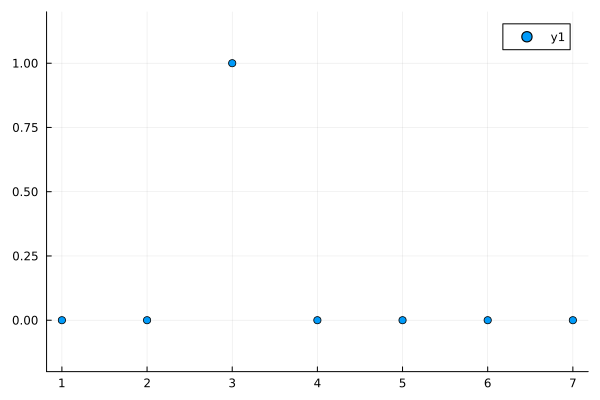

In [7]:
p_x = scatter(1:7, x, ylimits=(-0.2, 1.2))

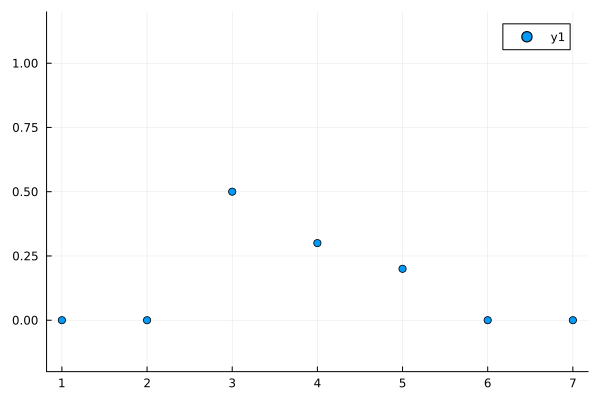

In [8]:
p_y = scatter(1:7, y, ylimits=(-0.2, 1.2))

In [9]:
function fir_ct1(b::NTuple{m,T}, x::Vector{T}) where {m,T}
    y = similar(x)

    for i in 1:length(x)
        if i < m
            y[i] = x[i]
        else
            sum = 0.0
            for k in 1:m
                sum += b[k] * x[i-(k-1)]
            end
            y[i] = sum
        end
    end
    return y
end

fir_ct1 (generic function with 1 method)

In [10]:
bt = (0.5, 0.3, 0.2)

(0.5, 0.3, 0.2)

In [11]:
fir_ct1(bt, x) ≈ y

true

In [12]:
using CompTime

In [13]:
include("MacroUtils.jl")
using .MacroUtils: cleanup

In [14]:
@ct_enable function fir_ct2(b::NTuple{m, T}, x::Vector{T}) where {m, T}
    y = similar(x)

    for i in 1:length(x)
        if i < m
            y[i] = x[i]
        else
            sum = 0.0
            for k in 1:m
                sum += b[k] * x[i-(k-1)]
            end
            y[i] = sum
        end
    end
    return y
end

runtime (generic function with 1 method)

In [15]:
fir_ct2(bt, x) ≈ y

true

In [16]:
@ct_enable function fir_ct3(b::NTuple{m, T}, x::Vector{T}) where {m, T}
    y = similar(x)

    for i in 1:length(x)
        if i < m
            y[i] = x[i]
        else
            sum = 0.0
            @ct_ctrl for k in 1:m
                sum += b[@ct k] * x[i- @ct(k-1)]
            end
            y[i] = sum
        end
    end
    return y
end

runtime (generic function with 2 methods)

In [17]:
fir_ct3(bt, x) ≈ y

true

In [18]:
debug(fir_ct3, bt, x) |> cleanup

quote
    y = similar(x)
    for i = 1:length(x)
        if i < m
            y[i] = x[i]
        else
            sum = 0.0
            sum += b[1] * x[i - 0]
            sum += b[2] * x[i - 1]
            sum += b[3] * x[i - 2]
            y[i] = sum
        end
    end
    return y
end

In [19]:
@ct_enable function fir_ct4(@ct(b), x)
    @ct m = length(b)
    y = similar(x)

    for i in 1:length(x)
        if i < @ct(m)
            y[i] = x[i]
        else
            sum = 0.0
            @ct_ctrl for k in 1:m
                sum += @ct(b[k]) * x[i- @ct(k-1)]
            end
            y[i] = sum
        end
    end
    return y
end

runtime (generic function with 3 methods)

In [20]:
fir_ct4(Val{bt}, x) ≈ y

true

In [21]:
debug(fir_ct4, Val{bt}, x) |> cleanup

quote
    y = similar(x)
    for i = 1:length(x)
        if i < 3
            y[i] = x[i]
        else
            sum = 0.0
            sum += 0.5 * x[i - 0]
            sum += 0.3 * x[i - 1]
            sum += 0.2 * x[i - 2]
            y[i] = sum
        end
    end
    return y
end